In [75]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn import cluster 
from nltk.tokenize import sent_tokenize, word_tokenize
from scipy.spatial.distance import cosine as cosine_distance
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn as nn
from torch import optim


import pickle

#device = torch.device('cuda:0')
device = torch.device('cuda:0')


In [62]:
alr_df = pd.read_csv('data/alr_dbscan_epsilon30.csv')

In [76]:
#alr_df

In [70]:
w2v_df = alr_df[alr_df['ClusterLabel'] > -1]

In [71]:
#w2v_df = w2v_df.drop_duplicates(subset=['Severity', 'SUBJECT', 'ClusterLabel'])
transactions = {}
for tid in  w2v_df['ClusterLabel'].values:
  transactions[tid] = []

w2v_df = w2v_df.sort_values('EVENT_DT_epoch')

for cid, sent in w2v_df[['ClusterLabel','SUBJECT']].values:
  transactions[cid].append(sent)




In [100]:
bagOfAlarms =  set(w2v_df['SUBJECT'].values)
alr2Idx = {w: idx for (idx, w) in enumerate(bagOfAlarms)}
idx2alr = {idx: w for (idx, w) in enumerate(bagOfAlarms)}

In [101]:
def transaction_to_idx_arry(transaction, alr2Idx):
  return [ alr2Idx[alrm] for alrm in transaction]

In [102]:
trans_list = [] 
for k in transactions:
  trans_list.append(transactions[k])

In [103]:
CONTEXT_SIZE = 3  # 2 words to the left, 2 to the right


# By deriving a set from `raw_text`, we deduplicate the array
vocab = bagOfAlarms
vocab_size = len(vocab)

alr_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for transact in trans_list:
    for i in range(CONTEXT_SIZE, len(transact) - CONTEXT_SIZE):
        context = (
            [transact[i - j - 1] for j in range(CONTEXT_SIZE)]
            + [transact[i + j + 1] for j in range(CONTEXT_SIZE)]
        )
        target = transact[i]
        data.append((context, target))


In [104]:
vocab_size = len(bagOfAlarms)
data_size = len(data)

print(vocab_size, data_size)

1672 342605


In [105]:
def make_context_vector(context, alr2Idx):
    idxs = [alr2Idx[w] for w in context]
    return idxs
    #return torch.tensor(idxs, dtype=torch.float)

In [106]:
data[0]

(['LinkDownPhysicalPort',
  'EquipmentDownPhysicalPort',
  'EquipmentDownPhysicalPort',
  'LinkDownPhysicalPort',
  'EquipmentDownPhysicalPort',
  'EquipmentDownPhysicalPort'],
 'LinkDownPhysicalPort')

In [107]:
alr2Idx['LinkDownPhysicalPort']

520

In [108]:
class Transaction2Vec(nn.Module):
  def __init__(self, embbedding_sz, vocab_size, context_sz):
    super(Transaction2Vec,self).__init__()
    self.embedding_shape = embbedding_sz
    self.l1 = nn.Linear(context_sz*2, embbedding_sz, bias=False)
    self.l2 = nn.Linear(embbedding_sz, vocab_size, bias=False)
    #self.l1 = nn.Linear(1, vocab_size, bias=False)
    #self.l1_2 = nn.Linear(vocab_size, embbedding_sz, bias=False)
    #self.l2 = nn.Linear(embbedding_sz, 10, bias=False)
    #self.out = nn.LogSoftmax(dim=0)

  def forward(self, x):
    x = x.to(device)
    x = self.l1(x)
    #x = self.l1_2(x)
    x = self.l2(x)
    #y = self.out(x)
    return x#y


In [112]:
batch_size =  512
embedding_dim = 300
epochs = 100
learing_rate = 0.0001
loss_func = nn.CrossEntropyLoss()
#loss_func = nn.MSELoss()

In [110]:
t2v = Transaction2Vec(embedding_dim, vocab_size, CONTEXT_SIZE)
optimizer = optim.Adam(t2v.parameters(), lr=learing_rate)
t2v.to(device)

Transaction2Vec(
  (l1): Linear(in_features=6, out_features=300, bias=False)
  (l2): Linear(in_features=300, out_features=1672, bias=False)
)

In [ ]:
hist_loss = []
i=0
for k in range(0,epochs):
  epoch_loss= []
  offset=0
  iteration = 0
  print(f'Epoch: {k}')
  while offset < data_size:

    this_batch = batch_size 
    if offset+batch_size > data_size:
      this_batch = data_size - offset
    X = []
    y = []
    for i in range(this_batch):
      y.append( [alr2Idx[data[offset+i][1]]])
      X.append( make_context_vector(data[offset+i][0], alr2Idx))
    offset += batch_size
    X = torch.tensor(X, dtype=torch.float).to(device)
    y = torch.tensor(y).to(device)
    #X = torch.tensor( [alr2Idx[data[i][1]]], dtype=torch.float ).to(device)
    #y = make_context_vector(data[0][0], alr2Idx).to(device)
    #if iteration % 100 == 0:
      #print(f'{100*iteration/((data_size/this_batch)*epochs)}% Complete')
    optimizer.zero_grad()
    o = t2v(X)
    #loss = loss_func(o.view(1,vocab_size), y )
    #loss = loss_func(o, y)
    loss = loss_func(o.view(this_batch,vocab_size,1),y)
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.to('cpu').detach().numpy())
    iteration += 1
  mn_loss = np.mean(epoch_loss)/this_batch
  print(f'Epoch {k}: Mean Loss {mn_loss}')
  hist_loss.append(np.mean(mn_loss))

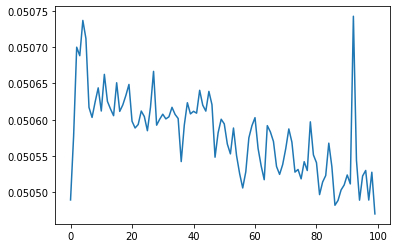

In [140]:
plt.plot(hist_loss)
plt.show()

In [141]:
torch.save({
    'epoch': 0,
    'model_state_dict': t2v.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }, "data\Tranasact2vec_202110191131.model")

In [142]:
stat_dict = torch.load(
    "data\Tranasact2vec_202110191131.model",   
    map_location="cpu"
    )

In [143]:
embedding = stat_dict["model_state_dict"]["l2.weight"].numpy()

In [144]:
embedding.shape

(1672, 300)

In [145]:
keyed_embeddings = {}
for alr in bagOfAlarms:
  keyed_embeddings[alr] = embedding[alr2Idx[alr]]


In [ ]:
alr2Idx

In [149]:
target_idx = 5
target = keyed_embeddings[idx2alr[target_idx]]
mini = 999
winner = 0
top10 = [target_idx]
top = 10
for k in range(top):
  for i in idx2alr:
    if i in top10:
      continue
    d = cosine_distance(target, keyed_embeddings[idx2alr[i]])
    if d < mini:
      mini = d 
      winner = i
  mini = 999
  top10.append(winner)
  target_idx = winner 
  target = keyed_embeddings[idx2alr[target_idx]]

for t in top10:
  print(idx2alr[t])

Link Down
InterfaceDown - NetworkInterface
CmmLSS_externalLinkDown - CMMInstance
PeerLacIngressEgressFault - SpokeSdpBinding
AccessInterfaceDown - LXAccessInterface
LabelProblem - SpokeSdpBinding
SdpBindingTunnelDown - SpokeSdpBinding
ServiceSiteDown - Site
AccessInterfaceDownLXAccessInterface
SdpBindingDown - SpokeSdpBinding
TunnelDown - Tunnel


In [150]:
transaction_embeddings = {}
for i, record in enumerate(w2v_df[['ClusterLabel', 'SUBJECT']].values):
  k = record[0]
  if k not in transaction_embeddings:
    transaction_embeddings[k] = []
  sent = record[1]
  target = keyed_embeddings[sent]
  transaction_embeddings[k].append(target)

In [151]:
for k in transaction_embeddings:
  transaction_embeddings[k] = np.array(transaction_embeddings[k]).mean(axis=0)

In [152]:
transaction_data = [] 
for k in  transaction_embeddings:
  transaction_data.append(transaction_embeddings[k])

len(transaction_data)

97000

In [153]:
transaction_data = np.array(transaction_data)

In [158]:
target_idx = 162
target = transaction_data[162]
mini = 999
winner = 0
top10 = [target_idx]
top = 10
for k in range(top):
  for i, vec in enumerate(transaction_data):
    if i in top10:
      continue
    d = cosine_distance(target, vec)
    if d < mini:
      mini = d 
      winner = i
  mini = 999
  top10.append(winner)
  target_idx = winner 
  target = transaction_data[target_idx]

for t in top10:
  print(t, )

162
15
18
25
52
63
66
67
68
69
70


In [164]:
# the transaction with cluster label 1 is pretty similar to 11, so the cosdist between those should be a good epsilon
cosine_distance(transaction_data[162], transaction_data[1063])

0.00014770030975341797

In [165]:
tdb = cluster.DBSCAN(eps=0.0001, min_samples=2, metric='cosine').fit(transaction_data)

In [166]:
t_labels = tdb.labels_

In [167]:
len(t_labels)

97000

In [168]:
print(len(set(t_labels)) - (1 if -1 in t_labels else 0))
print(np.max(t_labels))
max_label = np.max(t_labels) + 1

3998
3997


In [169]:
transaction_to_cluster = {"ClusterLabel": [], "TransactionClusterId":t_labels}
for i, k in enumerate(transaction_embeddings):
  transaction_to_cluster["ClusterLabel"].append(k)
  if t_labels[i] == -1:
    transaction_to_cluster["TransactionClusterId"][i] = k + max_label
  

In [ ]:
final_clustering = w2v_df.join(pd.DataFrame(transaction_to_cluster).set_index('ClusterLabel'), on="ClusterLabel")
final_clustering

In [171]:
#final_clustering = final_clustering.drop_duplicates(subset=['sentence', 'TransactionClusterId'])
final_clustering.set_index('EventId', inplace=True)

In [172]:
final_clustering.to_csv('data/final_clustering_subject_only.csv')

In [173]:
import pickle

In [174]:
with open('data/keyed_alarm_subject_embeddings.pickle', 'wb') as f:
  f.write(pickle.dumps(keyed_embeddings))

In [176]:
transaction_embeddings = {}
for i, record in enumerate(final_clustering[['TransactionClusterId', 'SUBJECT']].values):
  k = record[0]
  if k not in transaction_embeddings:
    transaction_embeddings[k] = []
  sent = record[1]
  target = keyed_embeddings[sent]
  transaction_embeddings[k].append(target)

for k in transaction_embeddings:
  transaction_embeddings[k] = np.array(transaction_embeddings[k]).mean(axis=0)

In [177]:
with open('data/transaction_subject_embeddings.pickle', 'wb') as f:
  f.write(pickle.dumps(transaction_embeddings))